# 噪声模拟器

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.2/mindquantum/zh_cn/mindspore_noise_simulator.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.2/mindquantum/zh_cn/mindspore_noise_simulator.py)&emsp;
[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.2/docs/mindquantum/docs/source_zh_cn/noise_simulator.ipynb)

MindQuantum 中包含各种噪声信道，利用噪声信道我们可以对真实的量子芯片进行模拟。在 MindQuantum 中，我们定义了各种 `ChannelAdder`，可以有选择性的在量子线路的不同位置添加噪声信道，依次完成含噪声的量子模拟。下面介绍如何利用 MindQuantum 完成此任务。

## ChannelAdder

`ChannelAdder` 是一个能够在量子线路特定位置添加特定信道的处理器，例如在测量门后添加比特翻转信道。`ChannelAdder` 类主要由三个函数构成，`_accepter()`、`_excluder()` 和 `_handler(BasicGate)`，其功能对应如下：

- `_accepter()`：返回一个由函数构成的列表，称为接受规则集，其中每个接受规则函数的输入都是一个量子门，当函数返回值为 `True` 时表示我们可以在该量子门后添加信道。

- `_excluder()`：返回一个由函数构成的列表，称为拒绝规则集，其中每个拒绝规则函数的输入都是一个量子门，当函数返回值为 `True` 时表示我们拒绝在该量子门后添加信道。

- `_handler(BasicGate)`：输入一个量子门，返回一段量子线路，表示在输入量子门后添加一段自定义的信道。

我们重定义类 `ChannelAdder` 的 `__call__` 函数，直接调用 `ChannelAdder` 即可生成处理后的量子线路。
下面介绍几种 `ChannelAdder`。

### BitFlipAdder

`BitFlipAdder` 的接口定义为：

```python
BitFlipAdder(flip_rate: float, with_ctrl=True, focus_on: int = None, add_after: bool = True)
```

该 `Adder` 会在量子门后添加一个比特翻转信道，接口的参数含义为：

- **flip_rate** (float)：比特翻转信道的翻转概率。
- **with_ctrl** (bool)：是否在控制位上添加比特。默认值： ``True``。
- **focus_on** (bool)：只将该噪声信道作用在 ``focus_on`` 比特上。如果为 ``None``，则作用在量子门的所有比特上。默认值： ``None``。
- **add_after** (bool)：是否在量子门后面添加信道。如果为 ``False``，信道将会加在量子门前面。默认值： ``True``。

例如，我们可以通过如下接口，在给定量子线路的每个量子门后都添加一个翻转概率为 ``0.3`` 的比特翻转信道：

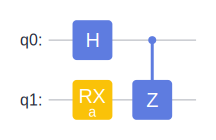

In [1]:
from mindquantum.core.circuit.channel_adder import BitFlipAdder
from mindquantum.core import gates as G
from mindquantum.core.circuit import Circuit

circ = Circuit()+G.H(0)+G.RX('a').on(1)+G.Z(1, 0)
circ.svg()

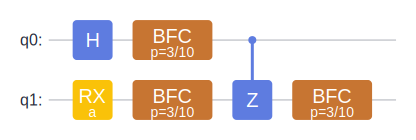

In [2]:
bit_flip_adder = BitFlipAdder(0.3, with_ctrl=False)
new_circ = bit_flip_adder(circ)
new_circ.svg()

### MeasureAccepter

```python
MeasureAccepter()
```

该 `Adder` 会选择对应的测量门，它目前只是一个 `Accepter`，不会改变量子线路中的任何门，需要利用 `MixerAdder`，跟其他的 `Adder` 搭配使用。

### MixerAdder

```python
MixerAdder(adders: typing.List[ChannelAdderBase])
```

`MixerAdder` 可以将多个 `Adder` 混合起来，保证量子门在每一个 `Adder` 中的接受函数集和拒绝函数集同时满足时，顺序添加 `_handler` 产生的量子线路。

举例来说，我们可以将上文提到的 `BitFlipAdder` 和 `MeasureAccepter` 混合起来，达到只在测量门前添加比特翻转信道的功能：

MixerAdder<
  BitFlipAdder<flip_rate=0.01, with_ctrl=True>
  MeasureAccepter<>
>


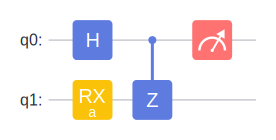

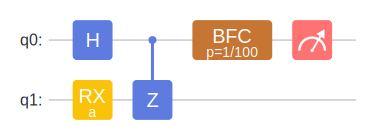

In [3]:
from IPython.display import display_svg
from mindquantum.core.circuit.channel_adder import MixerAdder, MeasureAccepter

mixer = MixerAdder([
    BitFlipAdder(flip_rate=0.01),
    MeasureAccepter(),
], add_after=False)
print(mixer)

circ = Circuit() + G.H(0) + G.RX('a').on(1) + G.Z(1, 0) + G.Measure().on(0)
display_svg(circ.svg())
new_circ = mixer(circ)
new_circ.svg()

### SequentialAdder

```python
SequentialAdder(adders: typing.List[ChannelAdderBase])
```

`SequentialAdder` 是由多个 `Adder` 顺序构成类，量子线路会经过 `SequentialAdder` 中的 `Adder` 依次处理，生成最终的量子线路。例如，我们想构建一个先在测量门前添加一个 $p=0.01$ 的比特翻转信道，然后在 `q1` 比特上的非测量门和非噪声信道后添加 $p=0.05$ 的去极化信道。

### 自定义 `Adder`

我们首先自定义在某个比特添加比特翻转信道的 `Adder`。

In [4]:
from mindquantum.core.circuit.channel_adder import ChannelAdderBase, SequentialAdder

class CustomDepolarizingAdder(ChannelAdderBase):
    def __init__(self, q, p):
        self.q = q
        self.p = p
        super().__init__()

    def _accepter(self):
        return [lambda x: self.q in x.obj_qubits or self.q in x.ctrl_qubits]

    def _excluder(self):
        return  [lambda x: isinstance(x, (G.Measure, G.NoiseGate))]

    def _handler(self, g):
        return Circuit([G.DepolarizingChannel(self.p).on(self.q)])

    def __repr__(self):
        return f"CustomDepolarizingAdder<q={self.q}, flip_rate={self.p}>"

seq_adder = SequentialAdder([
    MixerAdder([
        MeasureAccepter(),
        BitFlipAdder(flip_rate=0.01),
    ], add_after=False),
    CustomDepolarizingAdder(q=1, p=0.05),
])
print(seq_adder)

SequentialAdder<
  MixerAdder<
    MeasureAccepter<>
    BitFlipAdder<flip_rate=0.01, with_ctrl=True>
  >
  CustomDepolarizingAdder<q=1, flip_rate=0.05>
>


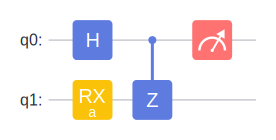

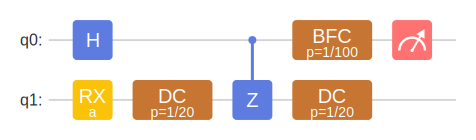

In [5]:
circ = Circuit() + G.H(0) + G.RX('a').on(1) + G.Z(1, 0) + G.Measure().on(0)
display_svg(circ.svg())
new_circ = seq_adder(circ)
new_circ.svg()

上述自定义量子信道也可以通过 MindQuantum 中的预定义信道搭建而成。

In [6]:
from mindquantum.core.circuit import ReverseAdder, NoiseExcluder, NoiseChannelAdder
seq_adder = SequentialAdder([
    MixerAdder([
        MeasureAccepter(),
        BitFlipAdder(flip_rate=0.01),
    ], add_after=False),
    MixerAdder([
        ReverseAdder(MeasureAccepter()),
        NoiseExcluder(),
        NoiseChannelAdder(G.DepolarizingChannel(0.05), focus_on=1),
    ])
])
print(seq_adder)

SequentialAdder<
  MixerAdder<
    MeasureAccepter<>
    BitFlipAdder<flip_rate=0.01, with_ctrl=True>
  >
  MixerAdder<
    ReverseAdder<
      MeasureAccepter<>
    >
    NoiseExcluder<>
    NoiseChannelAdder<channel=DC(p=1/20), with_ctrl=True>
  >
>


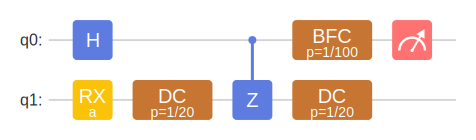

In [7]:
seq_adder(circ).svg()

### 更复杂的例子

下面我们来搭建一个更复杂的 `ChannelAdder` 例子，在该例子中，芯片的不同比特上的单比特门操作的噪声可以忽略不记，而双比特门在不同比特上具有不同的去极化信道，且线路的测量具有一个翻转概率为0.01的比特翻转错误。

我们假设不同比特上的去极化信道为：

In [8]:
dc0 = G.DepolarizingChannel(0.01)
dc1 = G.DepolarizingChannel(0.02)
dc2 = G.DepolarizingChannel(0.03)

然后，我们定义出满足要求的 `Adder`：

In [9]:
from mindquantum.core.circuit import QubitNumberConstrain
noise_adder = SequentialAdder([
    MixerAdder([
        NoiseExcluder(),
        ReverseAdder(MeasureAccepter()),
        QubitNumberConstrain(2),
        NoiseChannelAdder(dc0, focus_on=0),
    ]),
    MixerAdder([
        NoiseExcluder(),
        ReverseAdder(MeasureAccepter()),
        QubitNumberConstrain(2),
        NoiseChannelAdder(dc1, focus_on=1),
    ]),
    MixerAdder([
        NoiseExcluder(),
        ReverseAdder(MeasureAccepter()),
        QubitNumberConstrain(2),
        NoiseChannelAdder(dc2, focus_on=2),
    ]),
    MixerAdder([
        NoiseExcluder(),
        MeasureAccepter(),
        BitFlipAdder(0.01)
    ], add_after=False),
])
noise_adder

SequentialAdder<
  MixerAdder<
    NoiseExcluder<>
    ReverseAdder<
      MeasureAccepter<>
    >
    QubitNumberConstrain<n_qubits=2, with_ctrl=True>
    NoiseChannelAdder<channel=DC(p=1/100), with_ctrl=True>
  >
  MixerAdder<
    NoiseExcluder<>
    ReverseAdder<
      MeasureAccepter<>
    >
    QubitNumberConstrain<n_qubits=2, with_ctrl=True>
    NoiseChannelAdder<channel=DC(p=1/50), with_ctrl=True>
  >
  MixerAdder<
    NoiseExcluder<>
    ReverseAdder<
      MeasureAccepter<>
    >
    QubitNumberConstrain<n_qubits=2, with_ctrl=True>
    NoiseChannelAdder<channel=DC(p=0.03), with_ctrl=True>
  >
  MixerAdder<
    NoiseExcluder<>
    MeasureAccepter<>
    BitFlipAdder<flip_rate=0.01, with_ctrl=True>
  >
>

假设我们想要处理的量子线路是哈密顿量 $H=a_{01} Z_0Z_1 + a_{12} Z_1Z_2 + b_0 X_0 + b_1 X_1 + b_2 X_2$ 含时演化的一阶Trotter近似线路：

In [10]:
from mindquantum.core.operators import TimeEvolution, QubitOperator

ham = sum([
    QubitOperator('X0', 'b_0'),
    QubitOperator('X1', 'b_1'),
    QubitOperator('X2', 'b_2'),
    QubitOperator('Z0 Z1', 'a_01'),
    QubitOperator('Z1 Z2', 'a_12')
])
ham

 b_0 [X0] +
 b_1 [X1] +
 b_2 [X2] +
a_01 [Z0 Z1] +
a_12 [Z1 Z2]

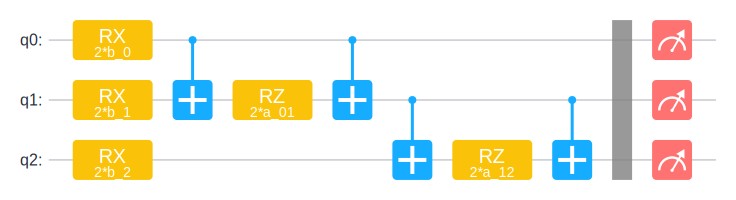

In [11]:
circ = TimeEvolution(ham).circuit
circ.barrier()
circ.measure_all()
circ.svg()

此线路经过上述定义的 `noise_adder` 处理后的量子线路为：

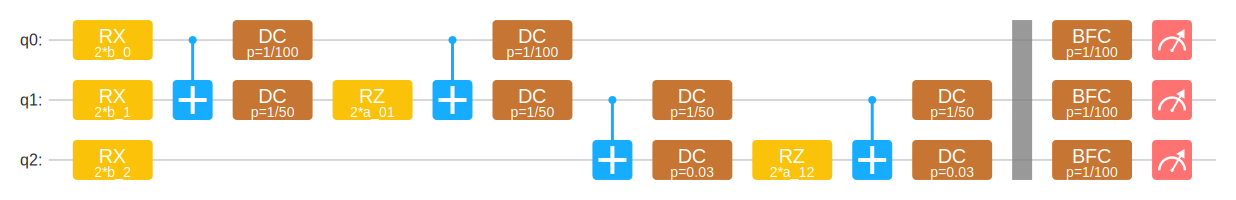

In [12]:
noise_adder(circ).svg()

### `ChannelAdder` 列表

下面列举出 MindQuantum 中现有的一些 `ChannelAdder`，并给出具体含义：

|`ChannelAdder`| 功能|
|--|--|
|ChannelAdderBase|在量子门前面或者后面添加信道|
|NoiseChannelAdder|添加一个单比特量子信道|
|MeasureAccepter|选取测量门|
|ReverseAdder|翻转给定信道添加器的接受和拒绝规则|
|NoiseExcluder|排除噪声门|
|BitFlipAdder|在量子门前面或者后面添加一个比特翻转信道|
|MixerAdder|在子添加器的接受集被满足、拒绝集被拒绝时依次执行所有的添加器|
|SequentialAdder|依次执行每一个添加器|
|QubitNumberConstrain|只将噪声信道作用在比特数为 ``n_qubits`` 的量子门上|
|QubitIDConstrain|只将噪声信道作用在给定比特序号的量子门上|
|GateSelector|选择想要的量子门添加信道|
|DepolarizingChannelAdder|添加去极化信道|

MindQuantum 中 `ChannelAdder` 的API接口文档请参考：[channel_adder](https://mindspore.cn/mindquantum/docs/zh-CN/r0.9/mindquantum.core.circuit.html#channel-adder)

## 基于 `ChannelAdder` 的噪声模拟器

我们可以将如上定义的各种 `Adder` 与现有的模拟器组合，构成一个含噪声模拟器。

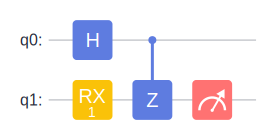

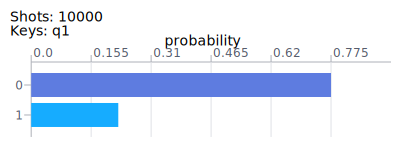

In [13]:
from mindquantum.simulator import Simulator
from mindquantum.simulator.noise import NoiseBackend

noiseless_sim = Simulator('mqvector', 2)
noiseless_circ = Circuit().h(0).rx(1.0, 1).z(1, 0).measure(1)
display_svg(noiseless_circ.svg())
res1 = noiseless_sim.sampling(noiseless_circ, shots=10000)
display(res1.svg())

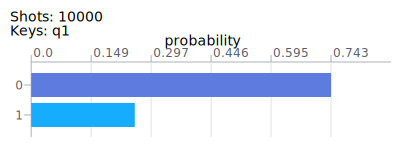

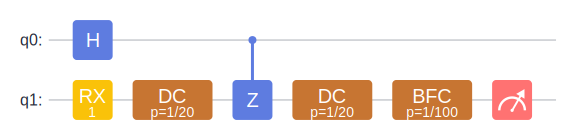

In [14]:
noise_sim = Simulator(NoiseBackend('mqvector', 2, seq_adder))
res2 = noise_sim.sampling(noiseless_circ, shots=10000)
display(res2.svg())
display(noise_sim.backend.transform_circ(noiseless_circ).svg())

In [15]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.9.0
scipy,1.10.1
numpy,1.21.6
System,Info
Python,3.9.13
OS,Linux x86_64
Memory,16.62 GB
CPU Max Thread,16
Date,Wed Aug 23 16:17:36 2023
